# Exercise 3: State space models

**Name**: Danil Gutak

**Student number**: 12215165

**Semester**: WS23

In this exercise, we learn about some Python tools to simulate time series with state space models, and fit state space models to time series. The fitted models can then be used for (short-term) preditions.

Please, first run the code below. It will import all modules and libraries for this exercise.

In [105]:
# necessary imports
import numpy as np
print("Numpy version: ", np.__version__)
from numpy import random
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]
print("Matplotlib version: ", matplotlib.__version__)
import pandas as pd
print("Pandas version: ", pd.__version__)
import datetime
import statsmodels
print("Statsmodels version: ", statsmodels.__version__)
import statsmodels.api as sm

Numpy version:  1.26.2
Matplotlib version:  3.8.2
Pandas version:  2.1.3
Statsmodels version:  0.14.1


## Part 1: Stochastic time series simulation with state space models

As an introduction to state space models, we will start by generating random time series from a state space model.

### Random sample generation

In order to simulate such a stochastic process in python, we use numpy's [random](https://numpy.org/doc/stable/reference/random/index.html?highlight=random%20sampling%20numpy%20random#module-numpy.random) submodule, which provides various methods for generating random samples.

To use it we first need to create a Random Number *Generator* (RNG) object. We will do this by writing `rng = `[`np.random.default_rng()`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng). Note that this method takes a single **optional** parameter, `seed`, which determines the random state. In other words, if we set seed to any integer number and run the code multiple times, the result will always be the same.

With the Generator created and assigned to the variable `rng` we can now use any of its methods, like so: `rng.method_name()`.

**Task:** Create a Random Number Generator object and use it to generate samples drawn from a Gaussian (normal) distribution with the [`.normal`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal) method. Choose any values for the mean, standard deviation and sample size by using the keyword arguments `loc`, `scale`, and `size` appropriately. Assign the output (i.e., the generated samples) to a variable and use numpy's `np.mean` and `np.std` functions to calculate the mean and standard deviation. Observe the difference between the mean and standard deviation of your samples and the values you entered into `.normal`. Quickly describe how the size parameter influences the difference. 

In [106]:
seed = 123456789
rng = np.random.default_rng(seed)
samples = rng.normal(loc=5.0, scale=2.0, size=1000)
print(np.mean(samples), np.std(samples))
samples = rng.normal(loc=5.0, scale=2.0, size=100000)
print(np.mean(samples), np.std(samples))

4.982810250865865 1.905884200675106
5.001020348844136 2.005077249463405


Description: As the size of the sample increases the accuracy of the mean and std compared to the actual parameters in .normal() method is getting closer.

### Time series for a random walk

The first state space model we will use is that for a "classical random walk,"

$$
x_{t+1} = a x_t + v_t.
$$

The process noise $v_t$ is a random variable and we will generate it by drawing from a Gaussian distribution with zero mean and a standard deviation of one, $v_t \sim \mathcal{N}(0, 1)$. To make it less complicated, we further assume that there is no measurment error, therefore, $y_t = x_t$. 

The code below will simulate `n` such random walks, with the number of time steps for each simulation run given by `steps`. 

In [107]:
# set parameters
n = 10 # number of time series to generate
steps = 1000 # number of steps per time series
t = np.arange(steps) # series of time steps for plotting
# create the numpy RNG object
rng = random.default_rng(seed)
# repeat for every time series
for j in range(n):
    # initialize the state variable with zero for every time step
    x = np.zeros(steps)
    # repeat for every simulation/time step
    for i in range(steps-1):
        # progress the state variable forward in time
        x[i+1] = x[i] + rng.normal(0, 1)

**Task:** Modify the code and plot the `n` generated time series (`t` on the x-axis and `x` on the y-axis) in one graph with matplotlib. Notice that above we set the state variable to zero for every simulation, $x_0 = 0$. You may alternatively randomize the initial condition `x[0]` by random sampling to make your time series start with different $x_0$ values.

*Hint:* If you want to reuse the same Python variable `x` in each simulation run, you have to do the plotting within the outer `for` loop (see code fragment below)!

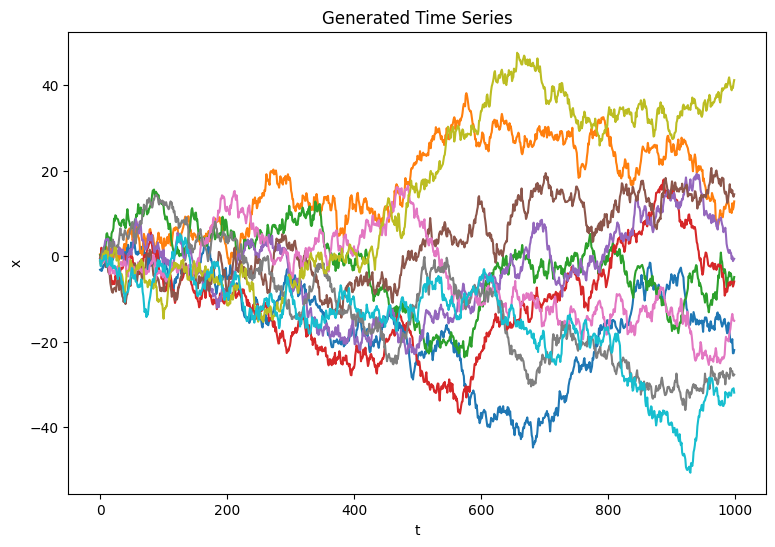

In [108]:

n = 10
steps = 1000
t = np.arange(steps)
x = np.zeros(steps)

fig, ax = plt.subplots()
for j in range(n):
    x[0] = rng.normal()
    for i in range(1, steps):
        x[i] = x[i-1] + rng.normal()
    ax.plot(t, x)

plt.xlabel('t')
plt.ylabel('x')
plt.title('Generated Time Series')
plt.show()

### Time series of linear trend with varying slope

Our next state space model is one that simulates a state that evolves linearly but changes its slope, as if the underlying process randomly speeds up or slows down over time,

$$
\textbf{x}_{t+1} = 
\begin{pmatrix}
1 & 1 \\
0 & 1 \\
\end{pmatrix}
\textbf{x}_t + \textbf{v}_t.
$$

In contrast to the random walk example, this state model uses two state variables, which are arranged into a state vector, $\textbf{x}_t = \begin{pmatrix}x_{t,~1} \\ x_{t,~2}\end{pmatrix}$. When we express the above matrix equation as a system of linear equations with a process noise vector, $\textbf{v}_t = \begin{pmatrix}0 \\ v_{t,~2}\end{pmatrix}$, we get

$$
x_{t+1,~1} = x_{t,~1} + x_{t,~2} \\
x_{t+1,~2} = x_{t,~2} + v_{t,~2}.
$$

Although only the equation for the second state variable $x_{t,~2}$ includes a stochastic element: $v_{t,~2} \sim \mathcal{N}(0,1)$, both are influenced by process noise because the time evolution of the first variable is determined also by the values of the second variable.

**Task:** Adapt the code from the random walk example to the state model defined above. Use a separate numpy array variable `x1` and `x2` for each state variable and plot your results.

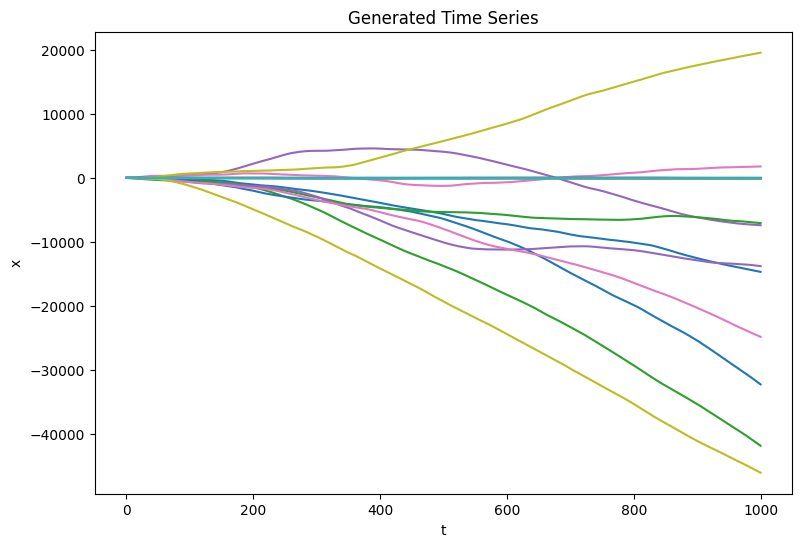

In [109]:
n = 10
steps = 1000
t = np.arange(steps)
x1 = np.zeros(steps)
x2 = np.zeros(steps)
fig, ax = plt.subplots()
for j in range(n):
    x1[0] = np.random.normal()
    x2[0] = np.random.normal()
    for i in range(1, steps):
        x1[i] = x1[i-1] + x2[i-1]
        x2[i] = x2[i-1] + np.random.normal()
    ax.plot(t, x1, label='x1')
    ax.plot(t, x2, label='x2')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Generated Time Series')
plt.show()
# here you can see that x1 is actually a random walk, while x2 is a random walk with drift and x1 is close to 0 while x2 is varying

## Part 2: Kalman filter and model fitting with maximum likelihood

In a realistic scenario, we observe not the state variables but noisy measurements of them. A Kalman filter can help us to estimate the state of a system from measurements (i.e., to "filter-out" the measurement noise). 

A Kalman filter operates by repeating two alternating steps, first it estimates the state of the system at the next time step based on the previous state. It then compares this estimate to the actual measured data, and uses this *a posteriori* knowledge to update its estimate of the system's state. This process is repeated over time, with the Kalman filter continuously updating its estimates with every measurement. 

When we want to apply a Kalman filter to a data set, we do not have to write everything from scratch. The Python module [`statsmodels`](https://www.statsmodels.org/stable/index.html) provides a variety of statistical models and other tools for statistical analysis and conveniently includes a [`KalmanFilter`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.kalman_filter.KalmanFilter.html#statsmodels.tsa.statespace.kalman_filter.KalmanFilter) class. This class generally implements a Kalman filter operating on a time series state space model. Another useful class contained in statsmodels is [`MLEModel`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEModel.html), which is based on the `KalmanFilter` class and further allows us to estimate model parameters via Maximum Likelihood Estimation (MLE). 

Below you can find some code, which adapts the `MLEModel` class for modelling a linear trend, similar to what we saw above. In particular, it defines how the model is structured by telling statsmodels how we want our measurement "output" matrix (called "`design` matrix" in statsmodels) and the transition matrix to look like.

However, don't worry if you don't fully understand how this code works. The syntax used here, is a bit more complicated as we saw before because it involves the definition of a new class (i.e., `LocalLinearTrend`, our own custom version of statsmodels `MLEModel` so to speak). Some major elements that would need to be changed to adapt to an alternative state space model are indicated in the comments below. 

In [110]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = 2 # ADAPT: dimension of state vector
        k_posdef = 1 # ADAPT: dimension of process noise vector

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )
        self.k_exog = 0

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0]) # ADAPT: output matrix
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]]) # ADAPT: state transition matrix
        self.ssm['selection'] = np.array([[0], [1]]) # ADAPT: effect of process noise

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*2

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1]

Now that we have setup our linear trend model, we can apply it to a time series data set. As in exercise 1 and 2 you may continue to work with your own time series or you can generate a brand new one by recalling what you just learned in part 1. If you would like to use your own time series, don't forget to reimport it first with `pd.read_csv`. 

To use the local linear trend model, first create a LocalLinearTrend object by typing `mymodel = LocalLinearTrend(mydata['mymeasurementcolumn'])`. Next, you can fit the model to your data using MLE by calling the [`.fit`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEModel.fit.html#statsmodels.tsa.statespace.mlemodel.MLEModel.fit) method on this object, like so: `myresult = mymodel.fit()`. This method will return a [`MLEResults`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.html#statsmodels.tsa.statespace.mlemodel.MLEResults) object, which contains all information about the fitted model and also allows you to use it. MLEResults object itself has a method called [`.predict`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.predict.html#statsmodels.tsa.statespace.mlemodel.MLEResults.predict), which you can use to predict the mean of your state variable for a certain time interval, e.g. `myresult.predict(start=99, end=199)`, will give you the model's predictions from your 100th to 200th data point. If your data set only contained 150 data points, the model will predict the remaining 50 data points into the future. You can also use the [`.get_prediction`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.get_prediction.html#statsmodels.tsa.statespace.mlemodel.MLEResults.get_prediction) method in the same way as `.predict` to return a [`PredictionResults`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.PredictionResults.html#statsmodels.tsa.statespace.mlemodel.PredictionResults) object that holds more details about your prediction, e.g., you can use it's [`.conf_int`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.PredictionResults.conf_int.html#statsmodels.tsa.statespace.mlemodel.PredictionResults.conf_int) method to get the confidence interval (at your preferred confidence level) for the predicted mean values.

**Task:** Fit a local linear trend model to a time series using the `LocalLinearTrend` class and use it to predict the state of your system for a time interval contained spanned by your data set (*in-sample* prediction) and for a time interval in the **near** future (*out-of-sample* prediction). What do you observe when you compare the confidence intervals for different time points and choosen time intervals? 

**Bonus Task:** Plot your measurements, predictions and confidence intervals in one plot. For plotting confidence intervals, we recommed you to use matplotlib's `.fill_between` [method](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.fill_between.html) or [function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html). 

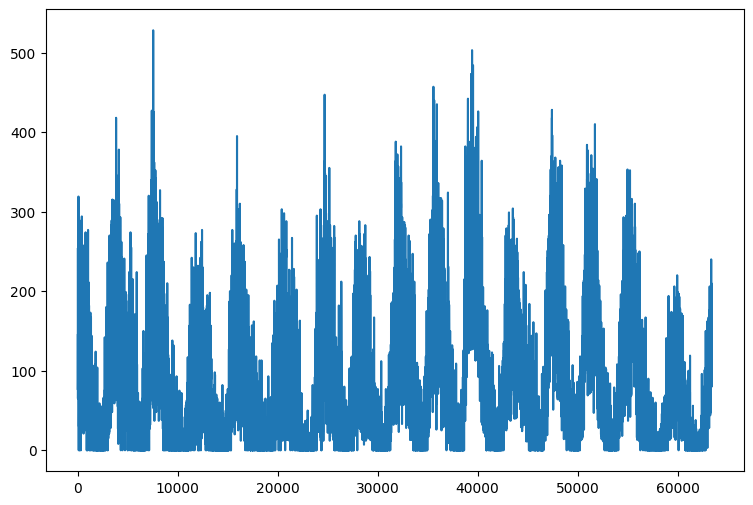

In [111]:
dataframe = pd.read_csv('daily_sunspots_time_series_1850_2023.csv', sep=',', comment='#')
data = dataframe['counts']
plt.plot(data)

In [112]:
model = LocalLinearTrend(data-data[0])
result = model.fit()
print(result.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.68995D+00    |proj g|=  6.19147D-02


 This problem is unconstrained.



At iterate    5    f=  4.58780D+00    |proj g|=  1.07841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8      9      1     0     0   7.998D-07   4.588D+00
  F =   4.5876230129526192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                           
Dep. Variable:                 counts   No. Observations:                63430
Model:               LocalLinearTrend   Log Likelihood             -290992.928
Date:                Tue, 16 Jan 2024   AIC                         581989.855
Time:                        22:41:42   BIC  

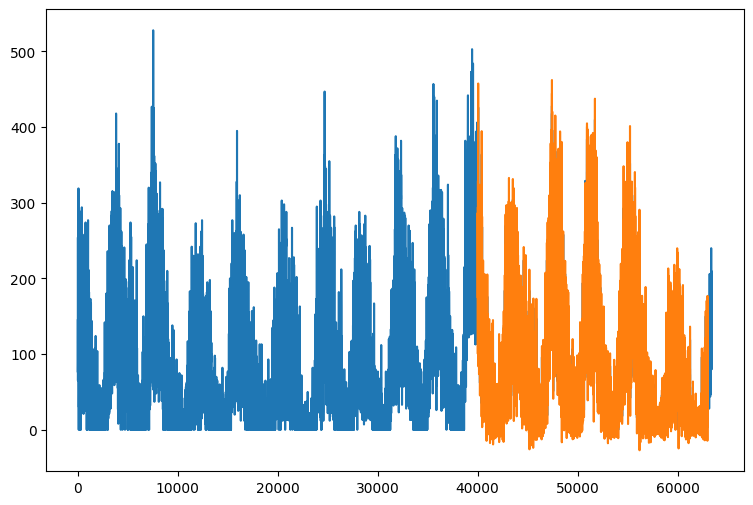

In [113]:
# lets predict in the data range 40000 to 63000
pred = result.predict(40000,63000) + data[0]
plt.plot(data)
plt.plot(pred)

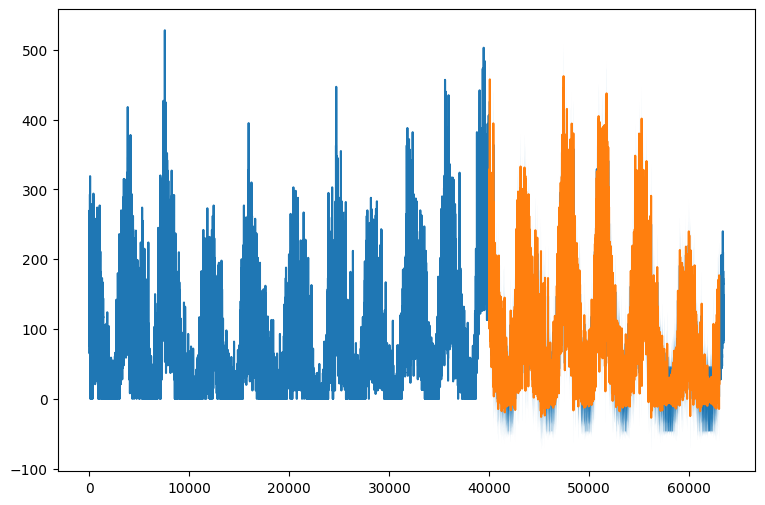

In [114]:
#lets look at the confidence interval
pred = result.get_prediction(40000,63000)
plt.plot(data)
ci = pred.conf_int()
plt.plot(ci.index, pred.predicted_mean + data[0])
plt.fill_between(ci.index, ci['lower counts'] + data[0], ci['upper counts'] + data[0])

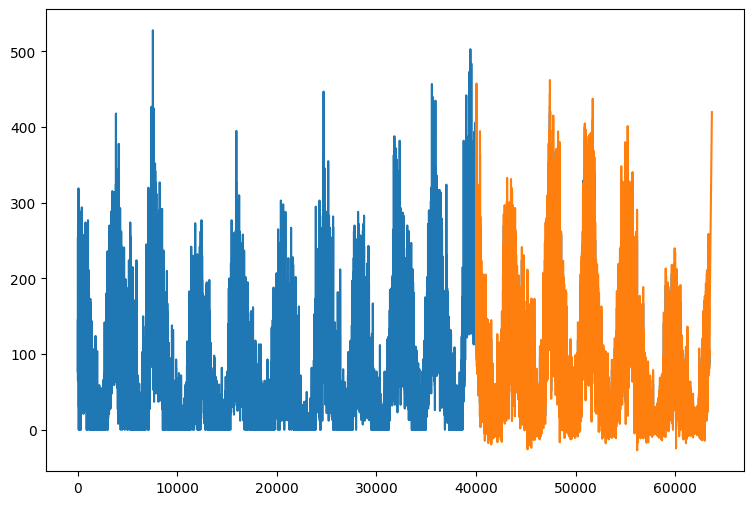

In [115]:
# lets predict in the data range 40000 to 63700 in future
pred = result.predict(40000,63700) + data[0]
plt.plot(data)
plt.plot(pred)

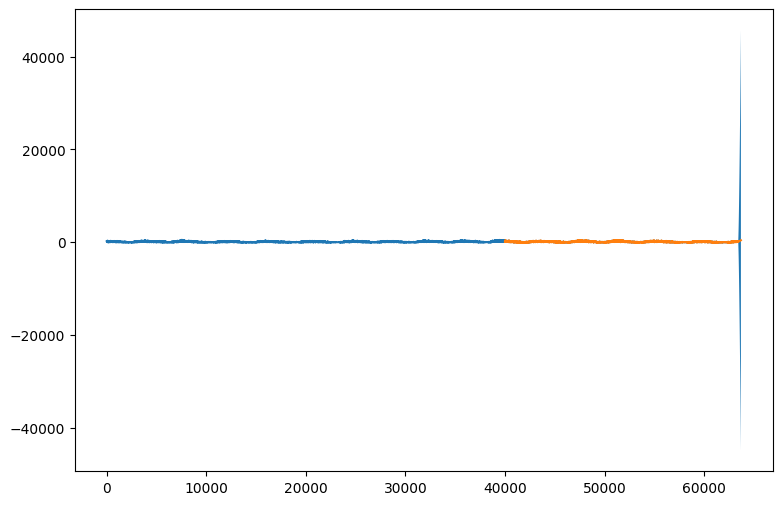

In [104]:
#lets look at the confidence interval
pred = result.get_prediction(40000,63700)
plt.plot(data)
ci = pred.conf_int()
plt.plot(ci.index, pred.predicted_mean + data[0])
plt.fill_between(ci.index, ci['lower counts'] + data[0], ci['upper counts'] + data[0])

DISCUSSION: As it can be seen the confidence intervals to compare are different across in and out prediction. Since the out prediction increases the confidence interval the further it goes it can be seen at some point it becomes so big it is hard to see the dynamics in in prediction. If compare this to the in prediction where we could see that confidence intervals are hardly deviate from the the prediction we can conclude that out prediction provides results with vaster confidence intervals